In [27]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pylab import rcParams

# Awesome plots
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import seaborn as sns

sns.set_style("whitegrid", {'axes.grid': True,
                            'axes.edgecolor': 'black'
                            })

# Load the dataset
X = np.load('ships_dataset/ship_data.npy')
t = np.load('ships_dataset/ship_labels.npy')

label_names = ['no_ship', 'ship']

X.shape, t.shape

((4000, 80, 80, 3), (4000,))

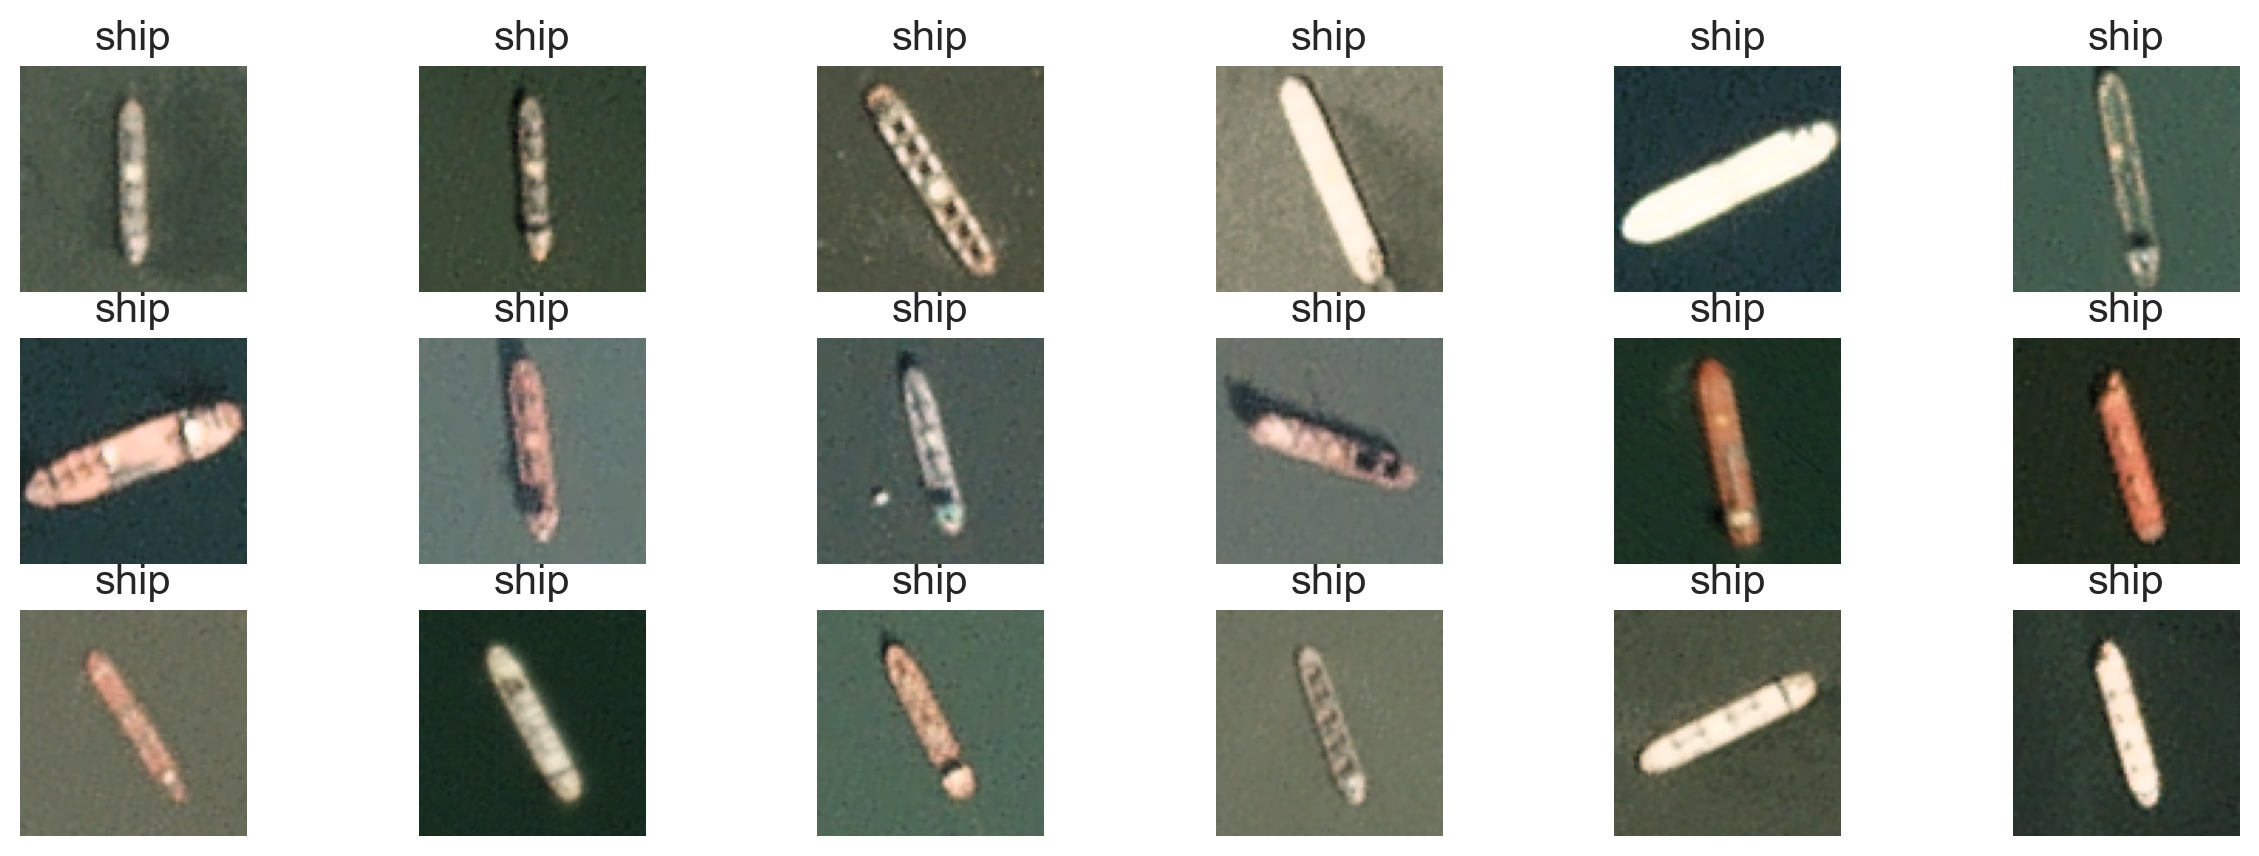

In [7]:
# ship images

rnd_sample = npr.permutation(np.where(t==1)[0])
fig=plt.figure(figsize=(15,5))
for j in range(18):
    fig.add_subplot(3,6,j+1)
    plt.imshow(X[rnd_sample[j]])
    plt.axis('off');plt.title(label_names[t[rnd_sample[j]]],size=15)
plt.show()
print('\n\n')

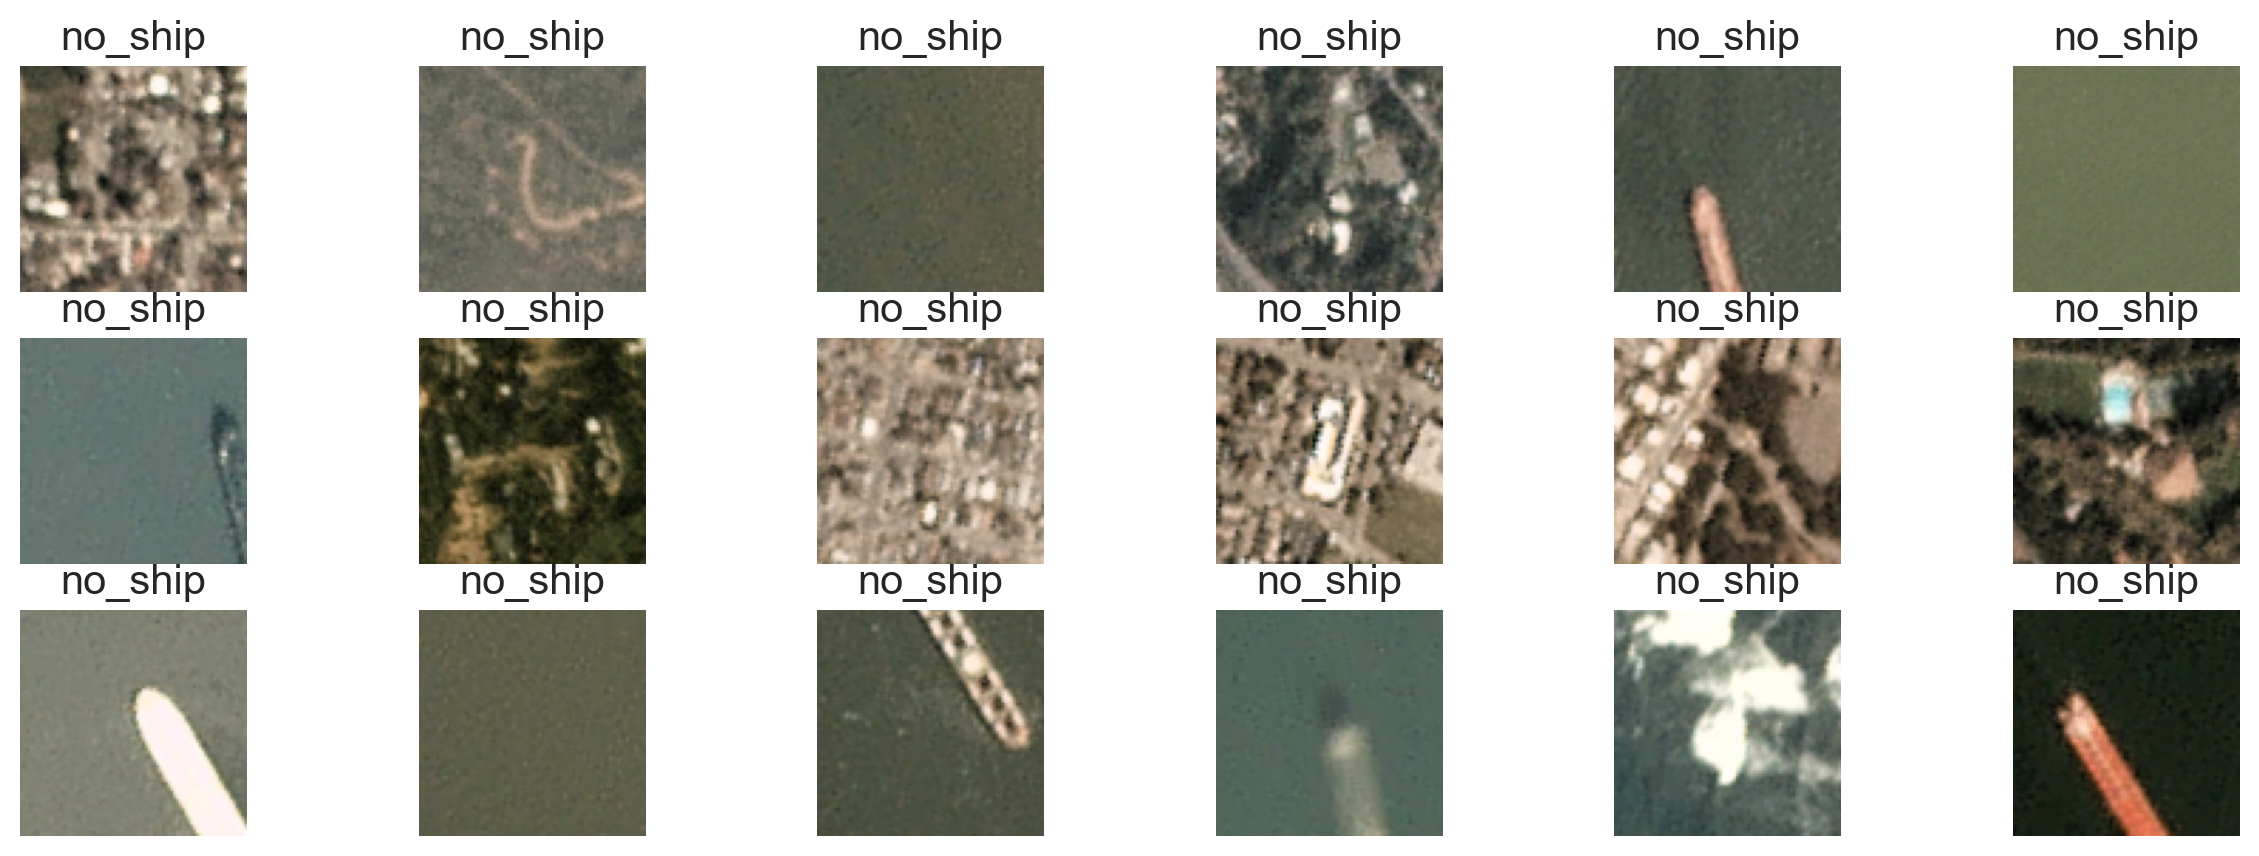

In [83]:
# no_ship images
plt.rcParams['text.usetex']=False
rnd_sample = npr.permutation(np.where(t==0)[0])
fig=plt.figure(figsize=(15,5))
for j in range(18):
    fig.add_subplot(3,6,j+1)
    plt.imshow(X[rnd_sample[j]])
    plt.axis('off');plt.title(label_names[t[rnd_sample[j]]],size=15)
plt.show()
print('\n\n')

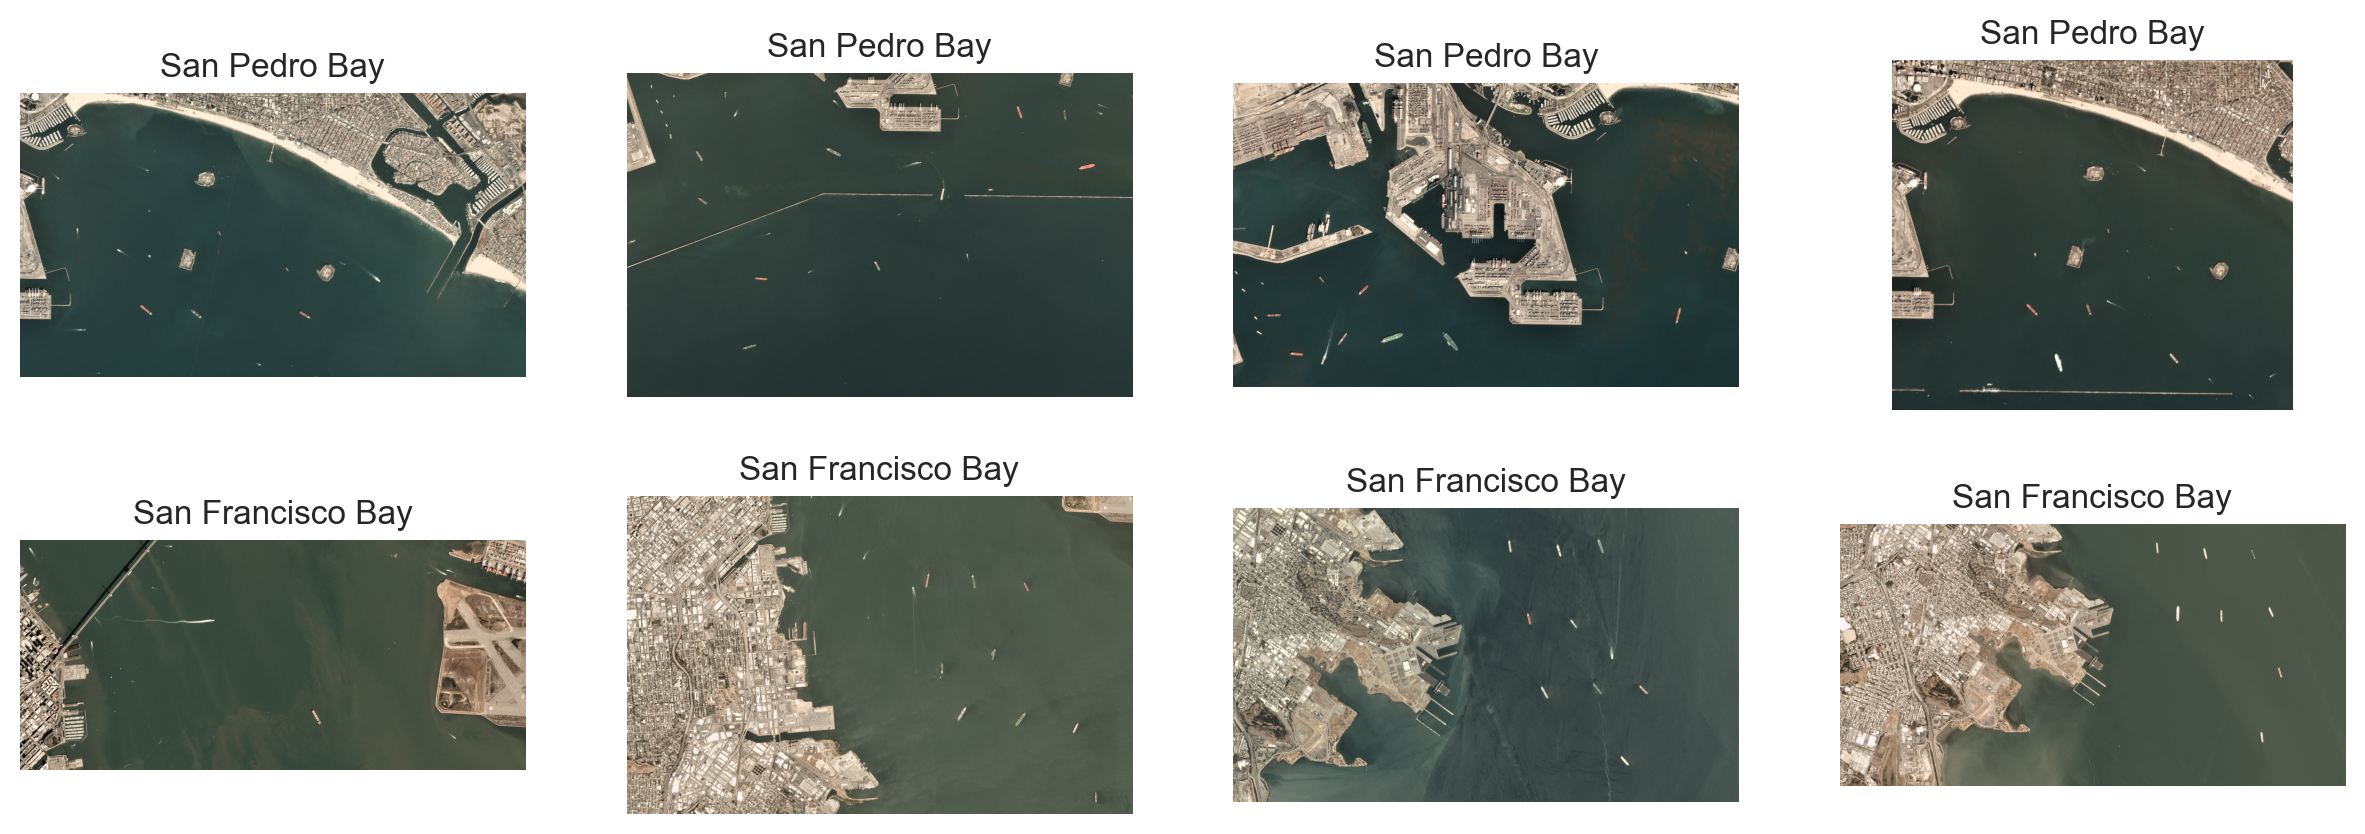

In [9]:
import os
from PIL import Image
bay_name = ['San Pedro Bay']*4 + ['San Francisco Bay']*4

directory = 'ships_dataset/scenes/'
plt.figure(figsize=(15,5))
j=1
for file in os.listdir(directory):
    if file.endswith('.png'):
        filename = directory+'/'+file
        # Loads image
        image = np.array(Image.open(filename).convert('RGB'))
        plt.subplot(2,4,j); plt.imshow(image); plt.axis('off');plt.title(bay_name[j-1])
        j+=1

In [88]:
import numpy as np

# Load the .npy file
data = np.load('ships_dataset/ship_data.npy')

# Check the shape of the data
print(f"Data Shape: {data.shape}")

# Calculate basic statistics
mean_pixel_value = np.mean(data)
std_pixel_value = np.std(data)
min_pixel_value = np.min(data)
max_pixel_value = np.max(data)

print(f"Mean Pixel Value: {mean_pixel_value:.2f}")
print(f"Standard Deviation of Pixel Values: {std_pixel_value:.2f}")
print(f"Min Pixel Value: {min_pixel_value}")
print(f"Max Pixel Value: {max_pixel_value}")

# Additional stat
median_pixel_value = np.median(data)
print(f"Median Pixel Value: {median_pixel_value}")

if data.ndim == 4:  # Assuming (num_images, height, width, channels)
    for channel in range(data.shape[-1]):
        channel_mean = np.mean(data[..., channel])
        channel_std = np.std(data[..., channel])
        print(f"Channel {channel} - Mean: {channel_mean:.2f}, Std Dev: {channel_std:.2f}")


Data Shape: (4000, 80, 80, 3)
Mean Pixel Value: 102.73
Standard Deviation of Pixel Values: 42.95
Min Pixel Value: 1
Max Pixel Value: 255
Median Pixel Value: 97.0
Channel 0 - Mean: 105.04, Std Dev: 48.43
Channel 1 - Mean: 108.19, Std Dev: 40.01
Channel 2 - Mean: 94.96, Std Dev: 38.64


In [86]:
t = np.load('ships_dataset/ship_labels.npy')

# Class distribution
unique, counts = np.unique(t, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)


Class Distribution: {0: 3000, 1: 1000}


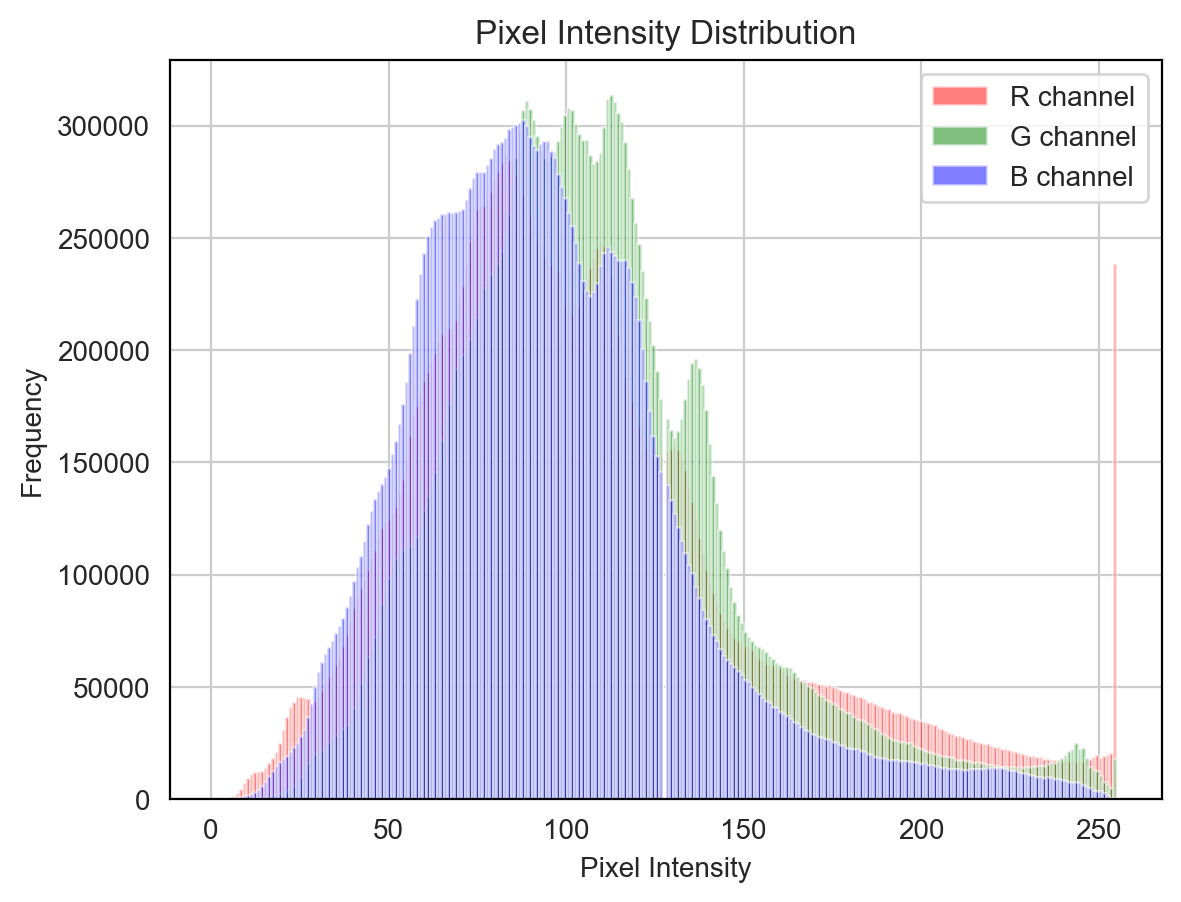

In [27]:
import matplotlib.pyplot as plt

# Reshaping
if X.shape[1] == 80 * 80 * 3:
    X = X.reshape(-1, 80, 80, 3)

# histogram of pixel intensities for each color channel
colors = ['r', 'g', 'b']
for i, color in enumerate(colors):
    plt.hist(X[:, :, :, i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.title('Pixel Intensity Distribution')
plt.show()


In [82]:
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Flatten images for training (reshaping to a 1D vector)
X = X.reshape(X.shape[0], -1)

# training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42, stratify=t)


In [84]:
# Save dataset splits
joblib.dump(X_train, "X_train.pkl")
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_train, "y_train.pkl")
joblib.dump(y_test, "y_test.pkl")


['y_test.pkl']

In [37]:
# pipeline for Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# hyperparameters
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(pipeline_rf, rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Train and time the model
start_time = time.time()
rf_grid_search.fit(X_train, y_train)
rf_train_time = time.time() - start_time

# best model
best_rf_model = rf_grid_search.best_estimator_


# Saving the trained model
joblib.dump(best_rf_model, 'rf_model.joblib')

# Outputs
print(f"Random Forest Training Time: {rf_train_time:.2f} seconds")
print("Best Random Forest Parameters:", rf_grid_search.best_params_)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Training Time: 617.88 seconds
Best Random Forest Parameters: {'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}


In [41]:
# pipeline and parameter grid for SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# hyperparameters
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# GridSearchCV for SVM
svm_grid_search = GridSearchCV(pipeline_svm, svm_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Train and time the model
start_time = time.time()
svm_grid_search.fit(X_train, y_train)
svm_train_time = time.time() - start_time

# Best model
best_svm_model = svm_grid_search.best_estimator_

# Saving the trained model
joblib.dump(best_svm_model, 'svm_model.joblib')

# Outputs
print(f"SVM Training Time: {svm_train_time:.2f} seconds")
print("Best SVM Parameters:", svm_grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Training Time: 609.67 seconds
Best SVM Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [43]:
# Evaluation on Training Data
rf_train_preds = best_rf_model.predict(X_train)
svm_train_preds = best_svm_model.predict(X_train)

print("Random Forest Training Accuracy:", accuracy_score(y_train, rf_train_preds))
print("Random Forest Training F1 Score:", f1_score(y_train, rf_train_preds))
print("SVM Training Accuracy:", accuracy_score(y_train, svm_train_preds))
print("SVM Training F1 Score:", f1_score(y_train, svm_train_preds))


Random Forest Training Accuracy: 0.9996875
Random Forest Training F1 Score: 0.9993753903810119
SVM Training Accuracy: 0.999375
SVM Training F1 Score: 0.99875


In [11]:
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Fit PCA to scaled data
pca = PCA()
pca.fit(X_scaled)

# cumulative variance and number of components required for 90% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components needed to explain 90% of variance: {n_components_90}")


Number of components needed to explain 90% of variance: 107


In [27]:
# pipeline for scaling and PCA
pipeline_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components_90))
])

# Fitting to data
pipeline_pca.fit(X_train)
X_reduced = pipeline_pca.transform(X_train)
X_reconstructed = pipeline_pca.inverse_transform(X_reduced)
X_reconstructed.shape

(3200, 19200)

In [93]:
X_train.shape

(3200, 19200)

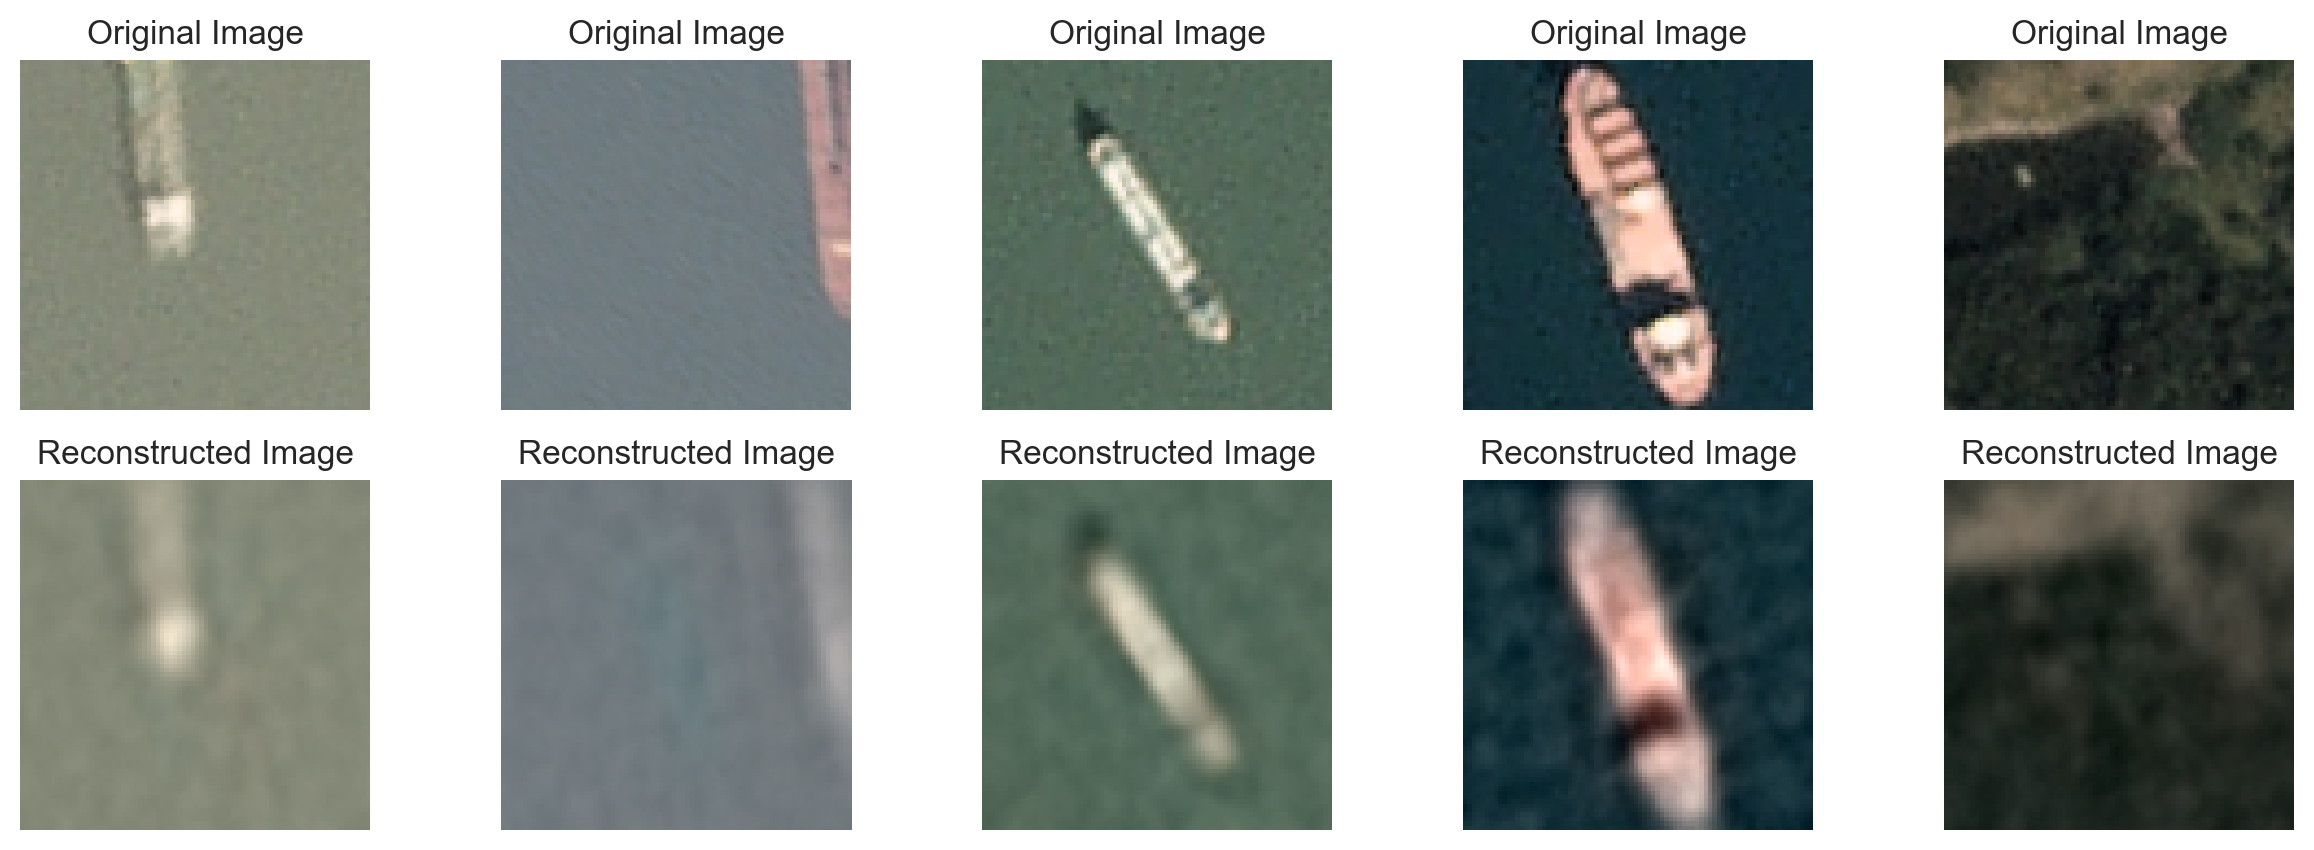

In [105]:
n_components_90 = 107

# Dimensionality reduction pipeline
dim_red = Pipeline([('scaler', StandardScaler()),
                   ('pca', PCA(n_components=n_components_90))])
dim_red.fit(X_train)

# Linear projections
ypca = dim_red.fit_transform(X_train)

# Reconstruction
X_reconst = dim_red.inverse_transform(ypca)
X_reconst = np.clip(X_reconst, 0, 255).astype(np.uint8)

# Visualizations
N = 5 # number of images to display
fig = plt.figure(figsize=(15,5))
idx = np.random.choice(range(X_reconst.shape[0]),replace=False,size=N)
j=1
for i in range(N):
    fig.add_subplot(2,N,j)
    plt.imshow(X_train[idx[i],:].reshape(80,80,3), cmap='gray')
    plt.axis('off')
    plt.title('Original Image');

    fig.add_subplot(2,N,j+N)
    plt.imshow(X_reconst[idx[i],:].reshape(80,80,3), cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed Image');
    j+=1


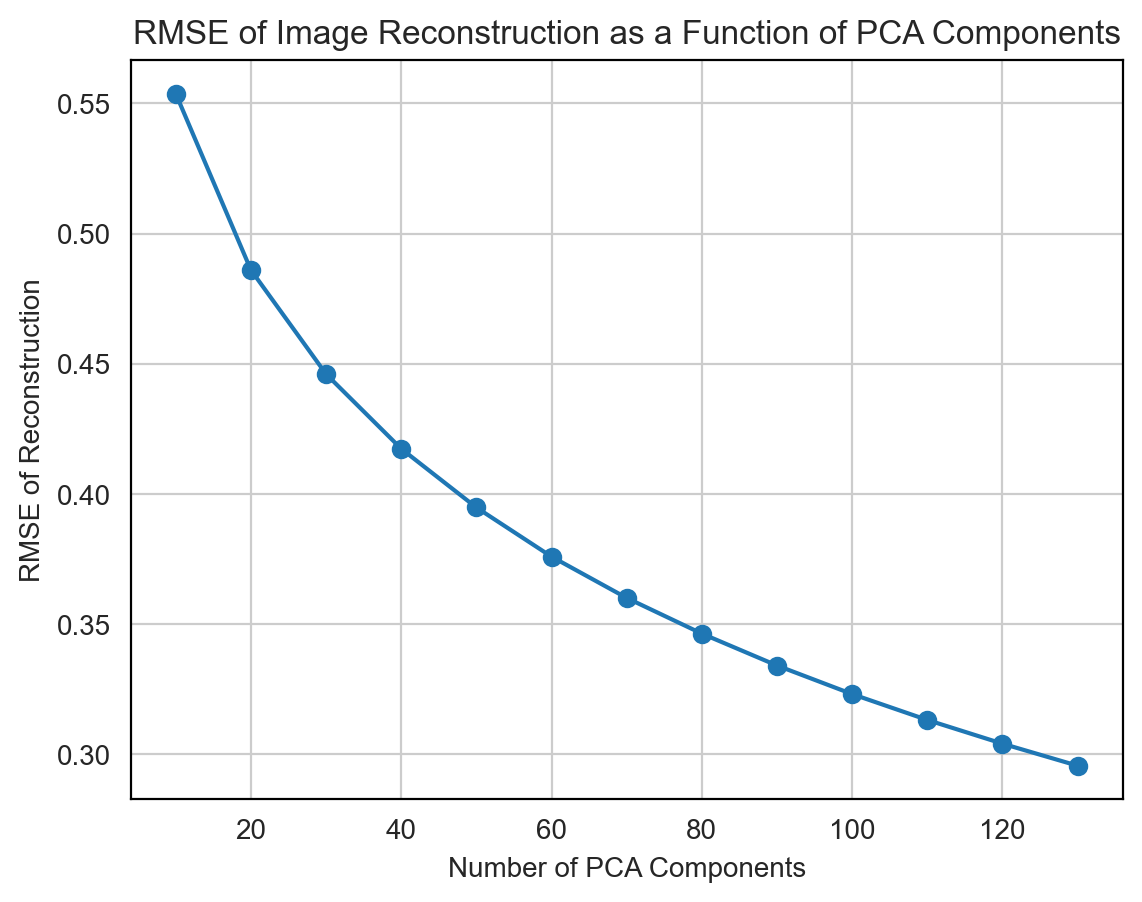

In [117]:
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE for a given number of PCA components
def calculate_rmse(n_components):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)
    X_reconstructed = pca.inverse_transform(X_reduced)
    rmse = np.sqrt(mean_squared_error(X_scaled, X_reconstructed))
    return rmse

# Calculate RMSE over a range of components
components_range = range(10, n_components_90 + 30, 10) 
rmse_values = [calculate_rmse(n) for n in components_range]

# Plot RMSE vs. number of components
plt.plot(components_range, rmse_values, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('RMSE of Reconstruction')
plt.title('RMSE of Image Reconstruction as a Function of PCA Components')
plt.show()


In [35]:
pca=PCA(n_components=107)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

# Define the parameter grids for each model with PCA
param_grid_svc_pca = {
    #'pca__n_components': pca_n_components,
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Create the pipelines
pipeline_svc_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svc', SVC())
])

# GridSearchCV for SVC with PCA
start_time = time.time()
grid_search_svc_pca = GridSearchCV(pipeline_svc_pca, param_grid_svc_pca, cv=5, scoring='f1')
grid_search_svc_pca.fit(X_train, y_train)
svc_pca_best_model = grid_search_svc_pca.best_estimator_
svc_pca_training_time = time.time() - start_time
print(f"SVC with PCA - Training Time: {svc_pca_training_time:.2f} seconds")

# Saving the trained model
joblib.dump(svc_pca_best_model, 'svc_pca_model.joblib')

SVC with PCA - Training Time: 951.97 seconds


['svc_pca_model.joblib']

In [37]:
y_train_svc_pca = svc_pca_best_model.predict(X_train)
svc_pca_accuracytrain = accuracy_score(y_train, y_train_svc_pca)
svc_pca_f1train = f1_score(y_train, y_train_svc_pca)

print(f"SVC with PCA - Best Params: {grid_search_svc_pca.best_params_}")
print(f"SVC with PCA - Accuracy: {svc_pca_accuracytrain:.4f}")
print(f"SVC with PCA - F1 Score: {svc_pca_f1train:.4f}\n")

SVC with PCA - Best Params: {'pca__n_components': 107, 'svc__C': 10, 'svc__kernel': 'rbf'}
SVC with PCA - Accuracy: 0.9959
SVC with PCA - F1 Score: 0.9918



In [31]:
pca_n_components = [10, 110]

param_grid_rf_pca = {
    'pca__n_components': pca_n_components,
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [10, 20, 50]
}

pipeline_rf_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=42))
])

# GridSearchCV for Random Forest with PCA
grid_search_rf_pca = GridSearchCV(pipeline_rf_pca, param_grid_rf_pca, cv=5, scoring='f1')
start_time = time.time()
grid_search_rf_pca.fit(X_train, y_train)
rf_pca_training_time = time.time() - start_time
rf_pca_best_model = grid_search_rf_pca.best_estimator_
print(f"Random Forest with PCA - Training Time: {rf_pca_training_time:.2f} seconds")


# Evaluation on training set
y_train_rf_pca = rf_pca_best_model.predict(X_train)
rf_pca_accuracytrain = accuracy_score(y_train, y_train_rf_pca)
rf_pca_f1train = f1_score(y_train, y_train_rf_pca)

print(f"Random Forest with PCA - Best Params: {grid_search_rf_pca.best_params_}")
print(f"Random Forest with PCA - Accuracy: {rf_pca_accuracytrain:.4f}")
print(f"Random Forest with PCA - F1 Score: {rf_pca_f1train:.4f}")

joblib.dump(rf_pca_best_model, 'rf_pca_model.joblib')

Random Forest with PCA - Training Time: 342.41 seconds
Random Forest with PCA - Best Params: {'pca__n_components': 110, 'rf__max_depth': 10, 'rf__n_estimators': 50}
Random Forest with PCA - Accuracy: 0.9981
Random Forest with PCA - F1 Score: 0.9962


In [59]:
from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

In [3]:
from sklearn.manifold import Isomap

In [45]:
# Isomap transformer
isomap = Isomap(n_components=3)
X_train_isomap = isomap.fit_transform(X_train)

# SVC Pipeline with Isomap
param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
   # ('isomap', isomap),
    ('svc', SVC())
])
print("\nTraining SVC with Isomap-transformed data:")
svc_grid_search = GridSearchCV(svc_pipeline, param_grid_svc, cv=5, scoring='f1')
start_time = time.time()
svc_grid_search.fit(X_train_isomap, y_train)
svc_training_time = time.time() - start_time

isomap_svc_model = svc_grid_search.best_estimator_
print(f"SVM with ISOMAP - Training Time: {svc_training_time:.2f} seconds")

joblib.dump(isomap_svc_model, "svc_isomap_best_model.pkl")


Training SVC with Isomap-transformed data:
SVM with ISOMAP - Training Time: 1.72 seconds


['svc_isomap_best_model.pkl']

In [17]:
# Test performance
y_train_svc = best_svc_model.predict(X_train_isomap)
svc_accuracytrain = accuracy_score(y_train, y_train_svc)
svc_f1train = f1_score(y_train, y_train_svc)

print(f"SVC with Isomap - Best Params: {svc_grid_search.best_params_}")
print(f"SVC with Isomap - Accuracy: {svc_accuracytrain:.4f}")
print(f"SVC with Isomap - F1 Score: {svc_f1train:.4f}\n")

SVC with Isomap - Best Params: {'svc__C': 10, 'svc__kernel': 'rbf'}
SVC with Isomap - Accuracy: 0.8994
SVC with Isomap - F1 Score: 0.7745



In [37]:
isomap = Isomap(n_components=3)

# Random Forest Pipeline with Isomap
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20]
}
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('isomap', isomap),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_grid_search = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='f1', verbose=2)
start_time = time.time()
rf_grid_search.fit(X_train, y_train)
rf_training_time = time.time() - start_time

isomap_rf_model = rf_grid_search.best_estimator_
print(f"Random Forest with ISOMAP - Training Time: {rf_training_time:.2f} seconds")

joblib.dump(isomap_rf_model, "rf_isomap_best_model.pkl")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ............rf__max_depth=None, rf__n_estimators=50; total time=   5.1s
[CV] END ............rf__max_depth=None, rf__n_estimators=50; total time=   4.6s
[CV] END ............rf__max_depth=None, rf__n_estimators=50; total time=   4.7s
[CV] END ............rf__max_depth=None, rf__n_estimators=50; total time=   4.5s
[CV] END ............rf__max_depth=None, rf__n_estimators=50; total time=   4.7s
[CV] END ...........rf__max_depth=None, rf__n_estimators=100; total time=   4.9s
[CV] END ...........rf__max_depth=None, rf__n_estimators=100; total time=   5.1s
[CV] END ...........rf__max_depth=None, rf__n_estimators=100; total time=   5.1s
[CV] END ...........rf__max_depth=None, rf__n_estimators=100; total time=   4.9s
[CV] END ...........rf__max_depth=None, rf__n_estimators=100; total time=   5.2s
[CV] END ...........rf__max_depth=None, rf__n_estimators=200; total time=   5.7s
[CV] END ...........rf__max_depth=None, rf__n_est

['rf_isomap_best_model.pkl']

In [13]:
# Train RF performance
y_train_rf = best_rf_model.predict(X_train)
rf_accuracytrain = accuracy_score(y_train, y_train_rf)
rf_f1train = f1_score(y_train, y_train_rf)

print(f"Random Forest with ISOMAP - Best Params: {rf_grid_search.best_params_}")
print(f"Random Forest with ISOMAP - Accuracy: {rf_accuracytrain:.4f}")
print(f"Random Forest with ISOMAP - F1 Score: {rf_f1train:.4f}\n")

Random Forest with ISOMAP - Best Params: {'rf__max_depth': None, 'rf__n_estimators': 200}
Random Forest with ISOMAP - Accuracy: 1.0000
Random Forest with ISOMAP - F1 Score: 1.0000



In [53]:
plt.rcParams["text.usetex"] = False

In [76]:
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    
    ax.plot(proj[:, 0], proj[:, 1], '.k', alpha=0.5)  
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            # Commenting out for debugging
            # if np.min(dist) < min_dist_2:
            
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap, zoom=0.5), proj[i]
            )
            ax.add_artist(imagebox)



ValueError: too many values to unpack (expected 2)

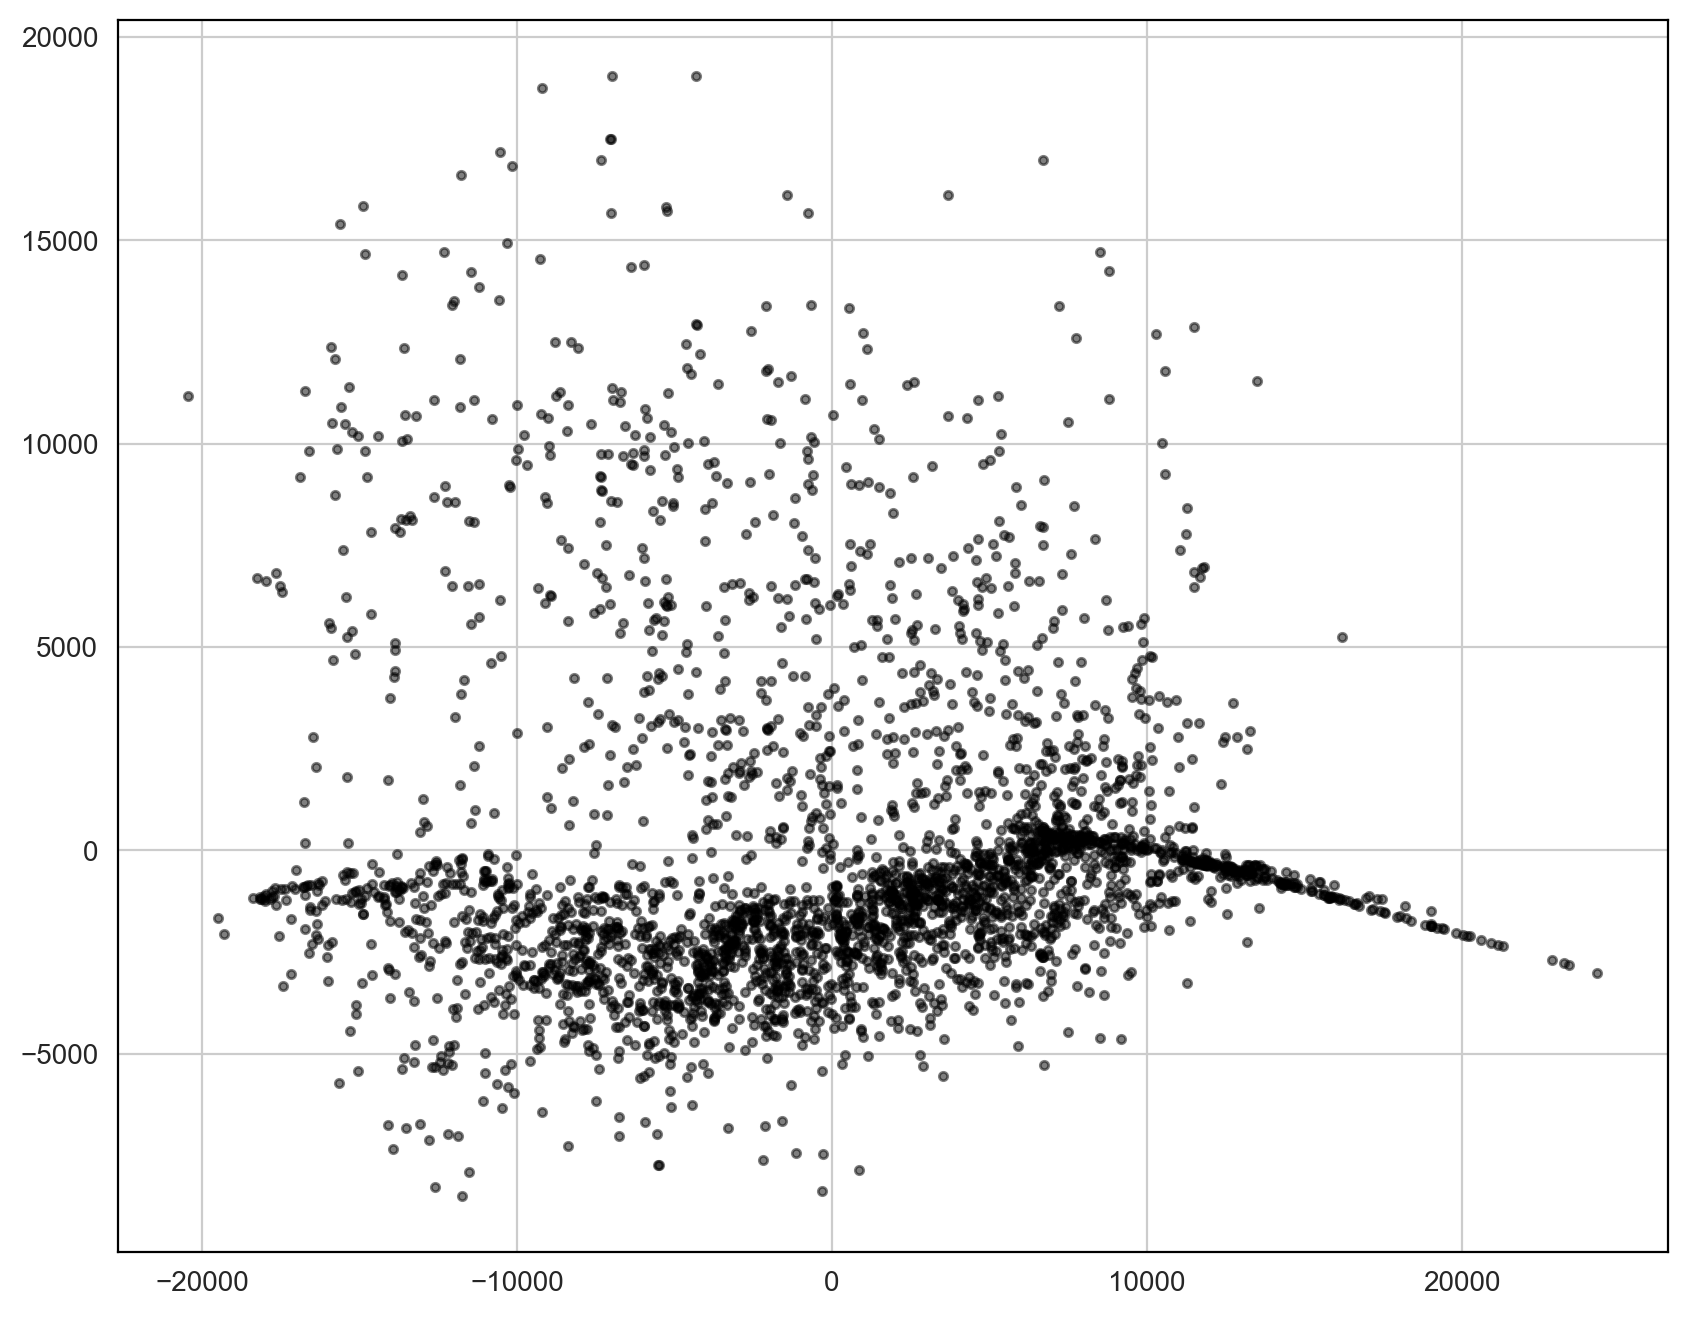

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_components(X_train, isomap, images=X_train.reshape(-1, 32, 32, 3), ax=ax)
ax.set_title("Isomap Components with Thumbnails (SVC)")
plt.show()

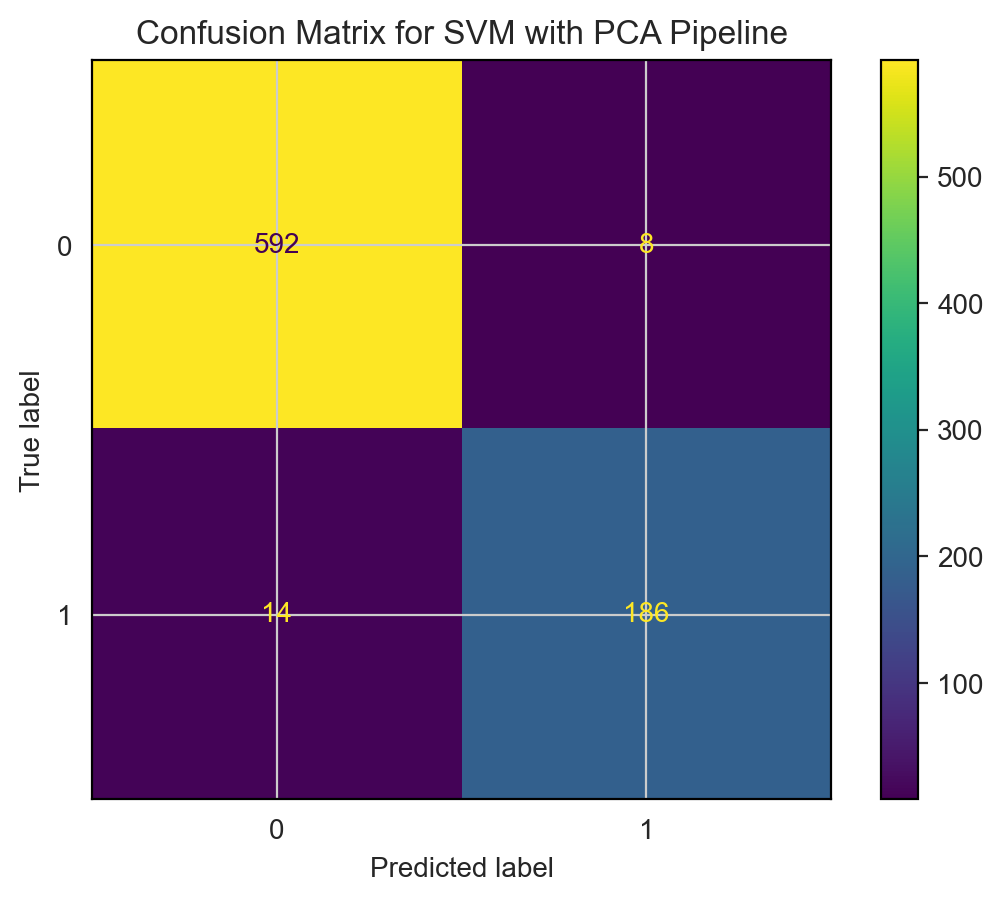

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm_svm_pca = confusion_matrix(y_test, y_pred_svc_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_pca)
disp.plot()
plt.title("Confusion Matrix for SVM with PCA Pipeline")
plt.show()

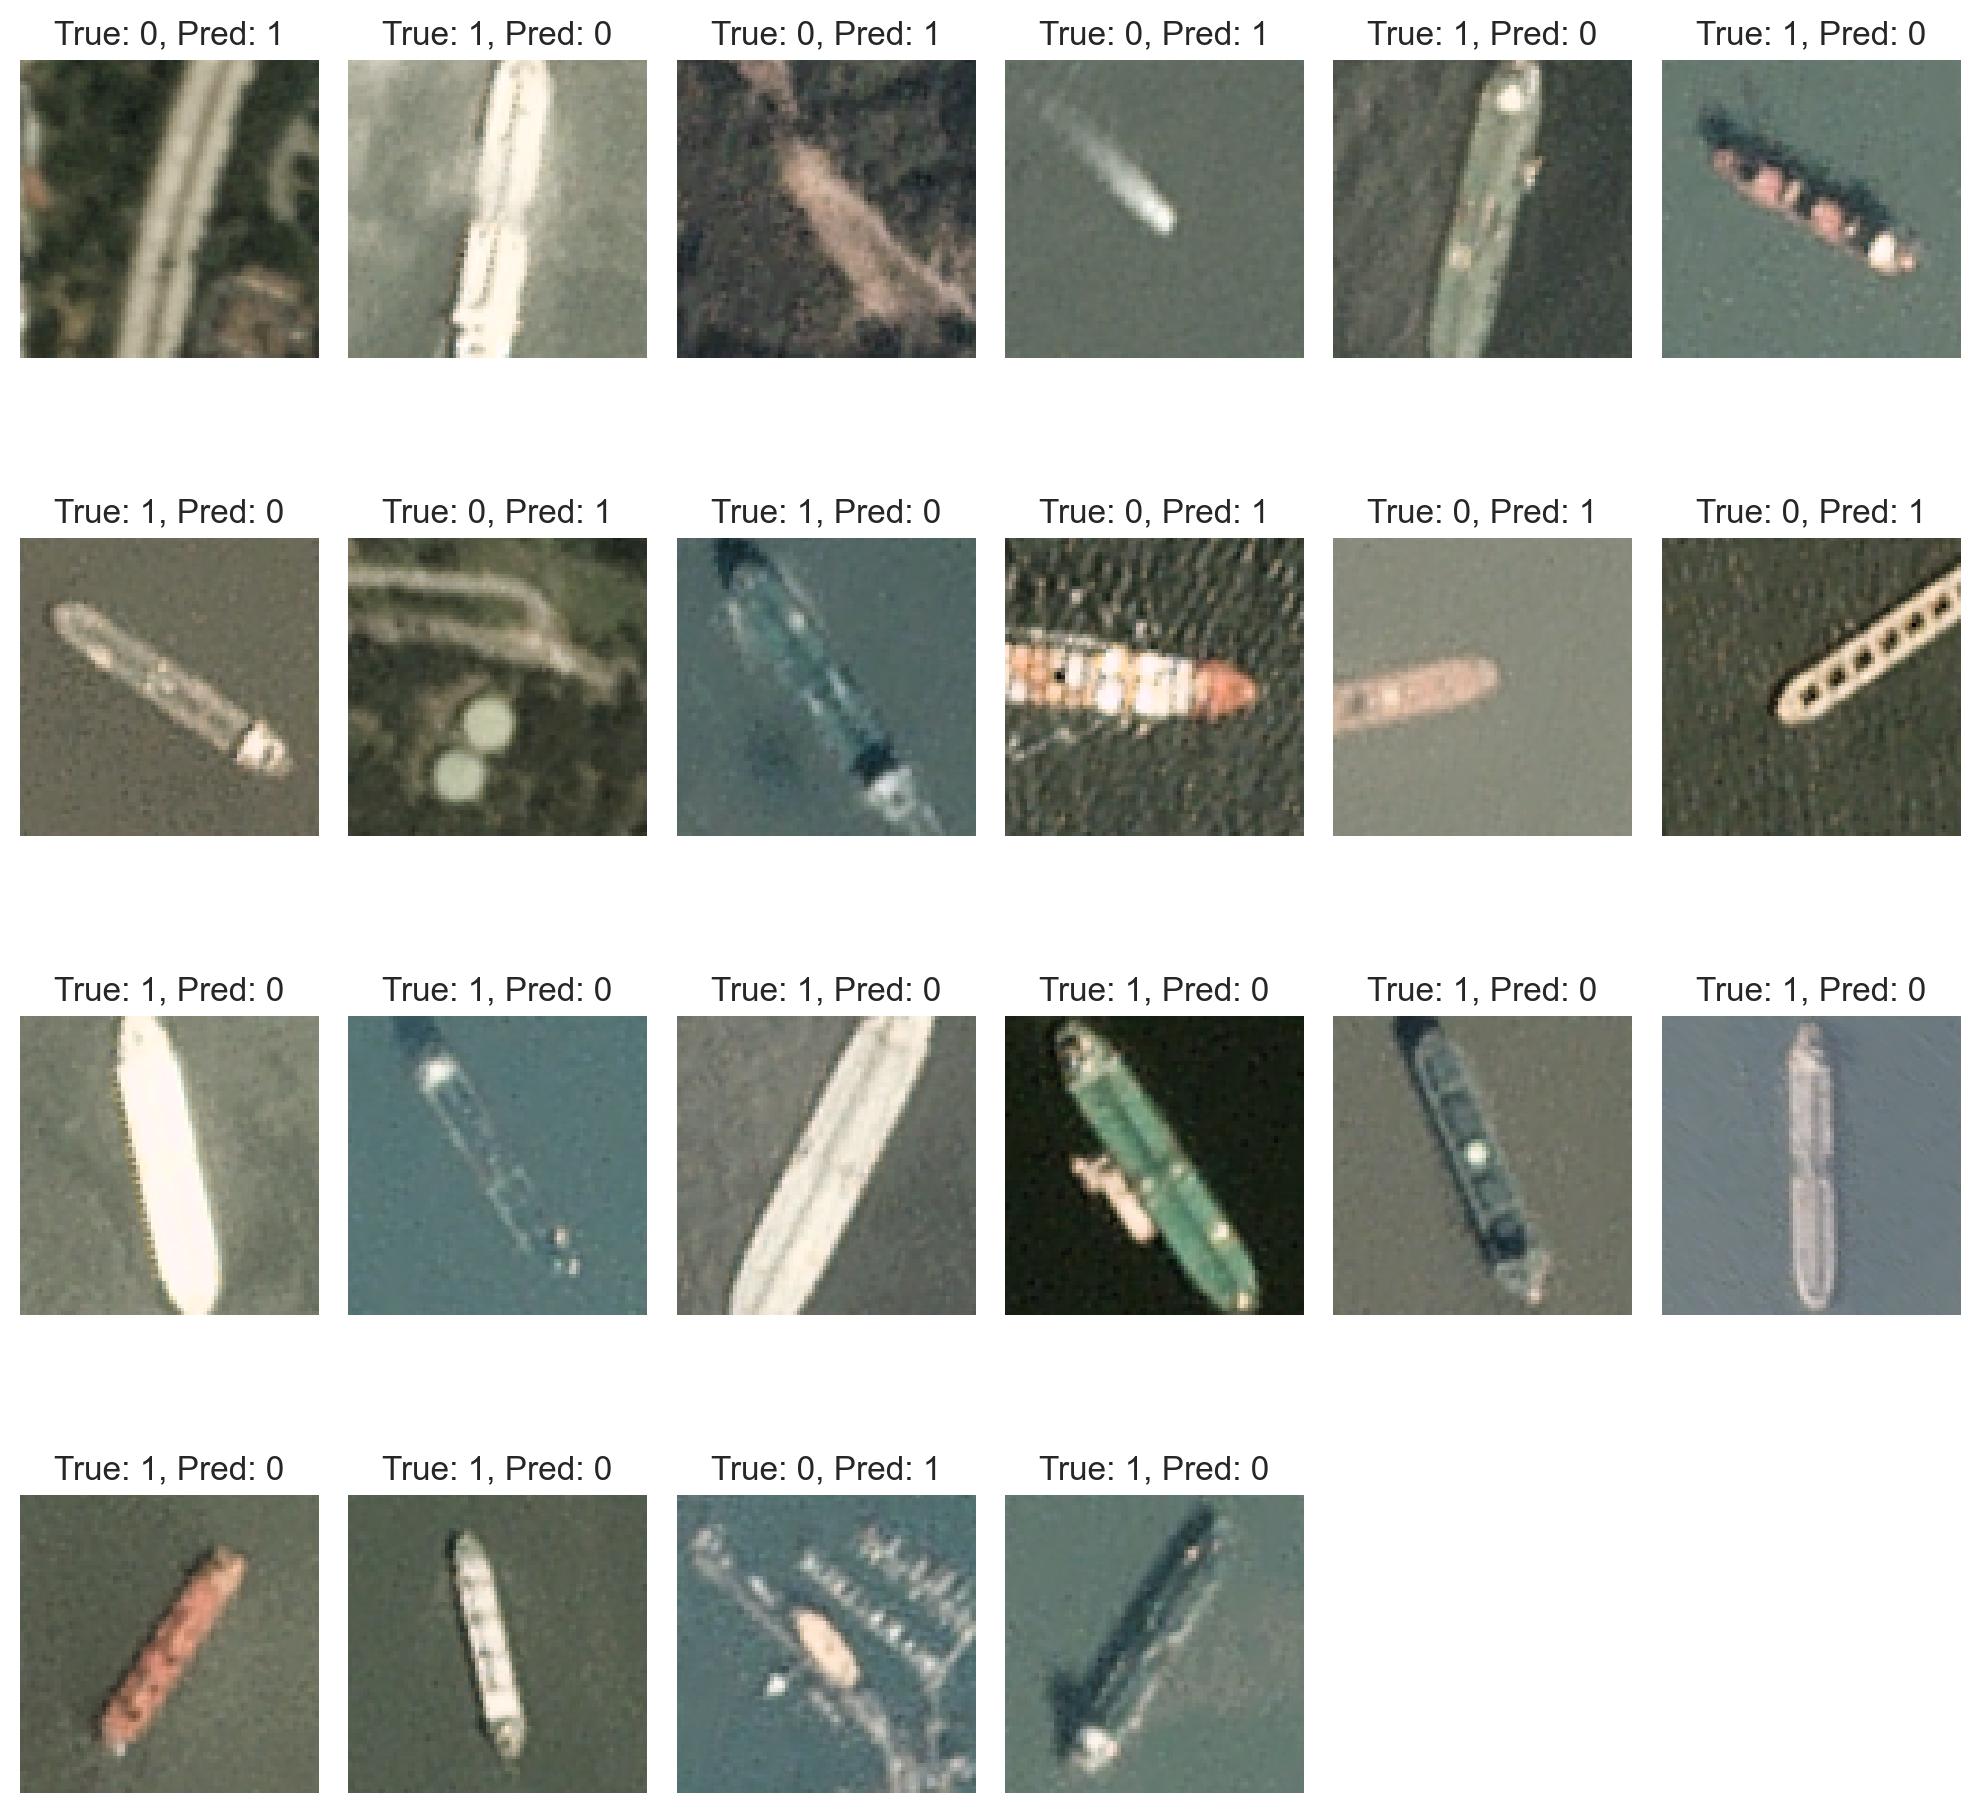

In [69]:
# Finding misclassified samples
misclassified_idx = np.where(y_test != y_pred_svc_pca)[0]

# Plot for misclassified samples
plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_idx[:]):  # Displaying all misclassified samples
    plt.subplot(4, 6, i + 1)
    plt.imshow(X_test[idx].reshape(80, 80, 3)) 
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred_svc_pca[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
